# structure

In [11]:
import ase 
from ase.build import bulk
from ase.visualize import view
from ase.io import write, Trajectory
from gpaw import GPAW, PW, FermiDirac, mpi
from ase.optimize import BFGS

import numpy as np
import matplotlib.pyplot as plt

from ase.dft.kpoints import bandpath
from gpaw.spinorbit import soc_eigenstates

from gpaw.response.df import DielectricFunction

In [12]:
lat=6.6; b=1.2
ang=90
st=0.6
CdTe=bulk('CdTe', 'zincblende', a=lat) 
view(CdTe)
write("CdTe_{0:.2f}.xyz".format(st),CdTe)
strain =np.arange(0,3,1)

In [13]:
def optimizacion(estr):
    calc=GPAW( mode=PW(650),
         xc='PBE',
         kpts=(14,14,14),
         occupations=FermiDirac(0.01),
        txt='CdTe_PW_opt.txt')
    estr.calc=calc
    opt = BFGS(estr)
    traj = Trajectory('path_opt.traj', 'w', estr)
    opt.attach(traj)
    opt.run(0.005)

def autoCons(estr,st):
    calc=GPAW( mode=PW(650),
         xc='PBE',
         kpts=(14,14,14),
         occupations=FermiDirac(0.01),
        txt='CdTe_PW_opt_estr_{0:.2f}.txt'.format(st))
    estr.calc=calc
    estr.get_potential_energy()
    calc.write('CdTe_Pw_estr_{0:.2f}.gpw'.format(st),'all')

def calcBandas(est,st,nomgpw):
    calc=GPAW(nomgpw).fixed_density(
        nbands=40,
        symmetry='off',
        kpts={'path': 'WLGXWK', 'npoints': 200},
        convergence={'bands': 8},
        txt= 'CdTe_PW_opt_estr_{0:.2f}_bandas.txt'.format(st))
    calc.write('CdTe_bandas_estr_{0:.2f}.gpw'.format(st),'all')
    
def bandasSOC(nomgpw,nomgpwband,inf,sup, nombre):
    calc=GPAW(nomgpwband, txt=None)
    ef=GPAW(nomgpw, txt=None).get_fermi_level()

    kpts,x,X=bandpath('WLGXWK', calc.atoms.cell, npoints=200)

    e_kn= np.array([calc.get_eigenvalues(kpt=k)[:20]
                   for k in range(len(calc.get_ibz_k_points()))])

    e_nk= e_kn.T
    e_nk-=ef

    for e_k in e_nk:
        plt.plot(x,e_k, '--',c='0.5')
    soc=soc_eigenstates(calc)
    e_mk=soc.eigenvalues().T
    e_mk-=soc.fermi_level

    plt.xticks(X, ['W', 'L', r'$\Gamma$', 'X', 'W', 'K'], size=20)
    plt.yticks(size=20)

    for i in range(len(X))[1:-1]:
        plt.plot(2*[X[i]], [-11,13],
                c='0.5', linewidth=0.5)
    for e_k in e_mk[::2]:
        plt.plot(x,e_k,c='b',lw=2)
    plt.plot([0.0,x[-1]], 2*[0.0], c='0.5')

    plt.ylabel(r'$\varepsilon_n(k)$ [eV]', size=24)
    plt.axis([0,x[-1],inf,sup])
    plt.tight_layout()
    #plt.savefig(nombre)
    plt.show()

# Spin-Orbit band calculation

/home/gabo/.local/lib/python3.6/site-packages/ase/dft/kpoints.py:357: UserWarning: Please do not use (kpts, x, X) = bandpath(...).  Use path = bandpath(...) and then kpts = path.kpts and (x, X, labels) = path.get_linear_kpoint_axis().
  warnings.warn('Please do not use (kpts, x, X) = bandpath(...).  '


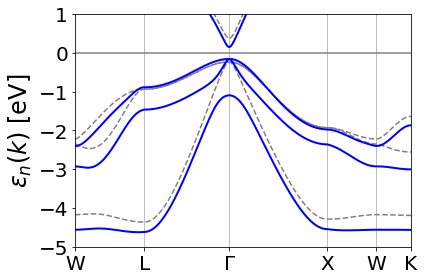

In [19]:
bandasSOC('CdTe_Pw_estr_0.00.gpw','CdTe_bandas_estr_0.00.gpw',-5,1, 'str_0.05_z.png')

# DOS

In [1]:
from gpaw import GPAW, restart
import matplotlib.pyplot as plt


Text(0, 0.5, 'DOS')

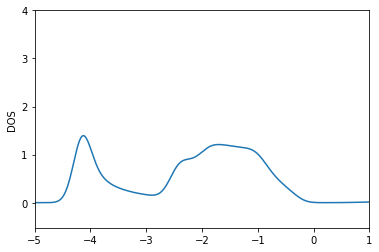

In [20]:
celda, calc= restart('CdTe_Pw_estr_0.00.gpw')
e,dos= calc.get_dos(spin=0, npts=2001, width=0.2)
e_f=calc.get_fermi_level()
plt.plot(e - e_f, dos)
plt.axis([-5, 1, None, 4])
plt.ylabel('DOS'); plt.